In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal

# 1. Get Data

In [2]:
# https://ourworldindata.org/covid-cases
cases = pd.read_csv('owid-covid-data.csv')

In [3]:
TARGETS = ['new_cases', 'total_cases']

In [4]:
cases_rus = (
    cases[(cases['location'] == 'Russia') & (cases['date'] >= '2020-03-03')]
    .sort_values('date')
    .reset_index(drop=True)
)

cases_rus['new_cases'] = np.where(cases_rus['new_cases'] == 0.0, 1.0, cases_rus['new_cases'])

train = cases_rus.iloc[:50]#.reset_index(drop=True)
test = cases_rus.iloc[50:]#.reset_index(drop=True)

print(f"Train shape : {train.shape}")
print(f"Train shape : {test.shape}")

Train shape : (50, 67)
Train shape : (1063, 67)


# 2. Simple exp model

## 2.1. Target variables distributions

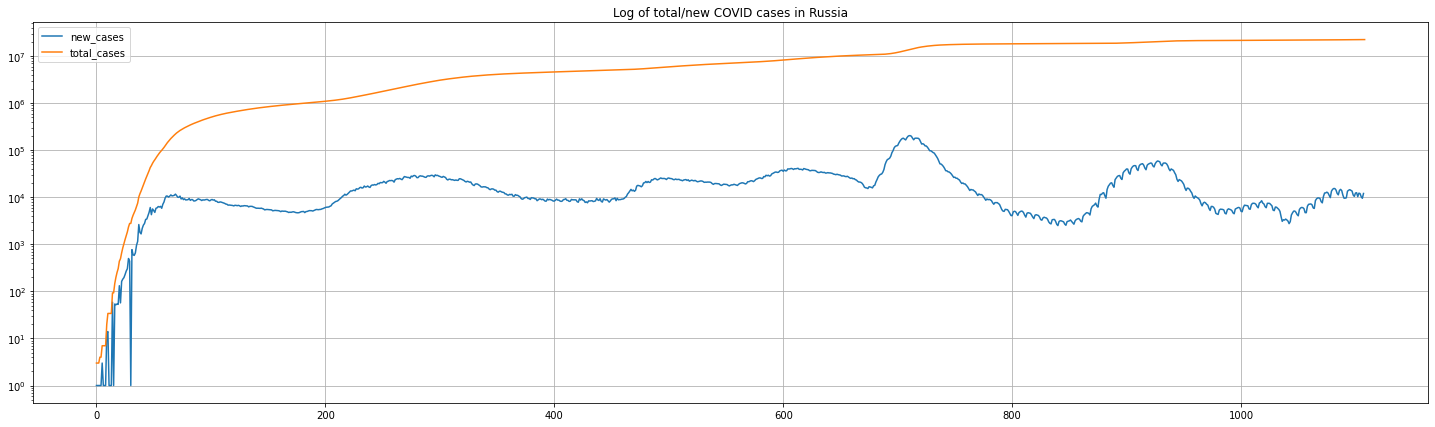

In [5]:
cases_rus[TARGETS].plot(
    grid=True,
    logy=True,
    figsize=(25, 7),
    title="Log of total/new COVID cases in Russia"
)

plt
plt.legend()
plt.show()

## 2.2 Train model $y = exp(x)$

Пусть $y = exp(ax + b)$, тогда $log(y) = ax + b$. 

Обучим линейную модель, для предсказания логарифма числа заболевших.

In [6]:
y_train = np.log(train['total_cases'])
y_test = np.log(test['total_cases'])
X_train = np.array(train.index).reshape(-1, 1)
X_test = np.array(test.index).reshape(-1, 1)

lin_reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)

y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

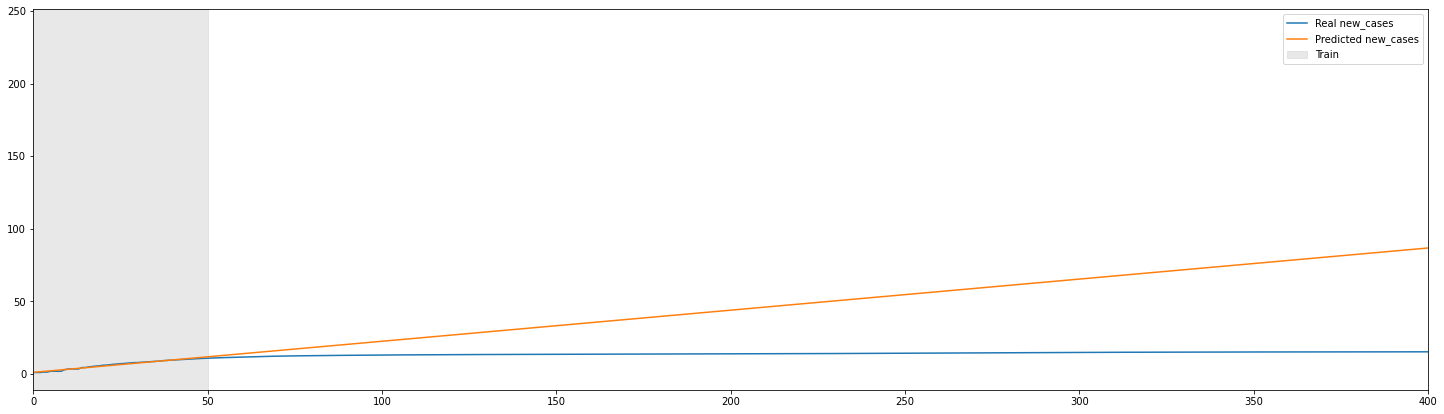

In [7]:
fig, ax = plt.subplots(figsize=(25, 7))

ax.plot(
    np.hstack((np.array(train.index), np.array(test.index))),
    np.hstack((y_train, y_test)), 
    label='Real new_cases'
)

ax.plot(
    np.hstack((np.array(train.index), np.array(test.index))),
    np.hstack((y_pred_train, y_pred_test)),
    label='Predicted new_cases'
)

ax.axvspan(0, 50, alpha=0.5, label = 'Train', color='lightgrey')
ax.set_xlim((0, 400))

plt.legend()
plt.show()

Видно, что модель очень сильно ошибается на тестовых данных, так как темпы роста заболеваемости замедляется после периода обучения (первые 50 дней).

## 2.3 Поиск апостерирорного распределения параметров

Возьмем значения коэффициентов регрессии, полученные с помощью МНК, в качестве средних значений априорного распределения наших параметров

In [8]:
sigma_noise = np.std(y_train - y_pred_train)
b = lin_reg.intercept_
a = lin_reg.coef_[0]
true_mu = [b, a]

xd = X_train.copy()
data = y_train.copy()


print(f"Posterior sigma = {sigma_noise}")
print(f"Fitted params: {b=}, {a=}")

Posterior sigma = 0.4498899109116323
Fitted params: b=1.1934192756385693, a=0.2141063665825282


In [9]:
figsize = (12,6)

def get_likelihood(px, py, sigma=.5):
    return lambda x : np.exp(-(x[0] + x[1]*px - py) ** 2) / (2 * sigma * np.sqrt(2.*np.pi))

def myplot_heatmap(Z, xlim=(-1, 1), ylim=(-1, 1)):
    # Make the plot
    plt.axis('equal')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.scatter(true_mu[0], true_mu[1], marker='*', s=120)

def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

Априорное распределение с центрами в 0 и дисперсиями 2, как на лекции.

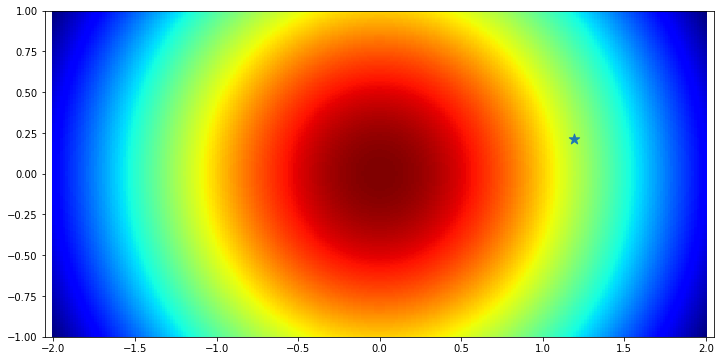

In [10]:
N = 250

xs = np.linspace(-3, 3, N)
X = np.linspace(-2, 2, N)
Y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

cur_mu, cur_sigma = np.array([0, 0]), 2 * np.array([[1, 0], [0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_heatmap(Z)

In [11]:
num_steps = X_train.shape[0]

for i in range(num_steps):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, xd[i][0], data[i], sigma_noise)

print(f"Апостериорное распределение параметров: {cur_mu}")

Апостериорное распределение параметров: [1.18416525 0.21438625]


## 2.3. Сэмплируем и строим экспоненты

In [12]:
def myplot_sample_exp(mu, sigma, n=20, points=None):
    # Немного модифицируем функцию с лекции, чтобы она строила экспоненты
    my_w = np.random.multivariate_normal(mu, sigma, n)
    plt.figure(figsize=(20, 15), dpi=80)
    for w in my_w:
        plt.plot(xd, np.exp(w[0] + w[1]*xd), 'k-', lw=.4)
    if not points is None:
        plt.scatter(points[0], np.exp(points[1]), marker='*', s=200)
    plt.show()

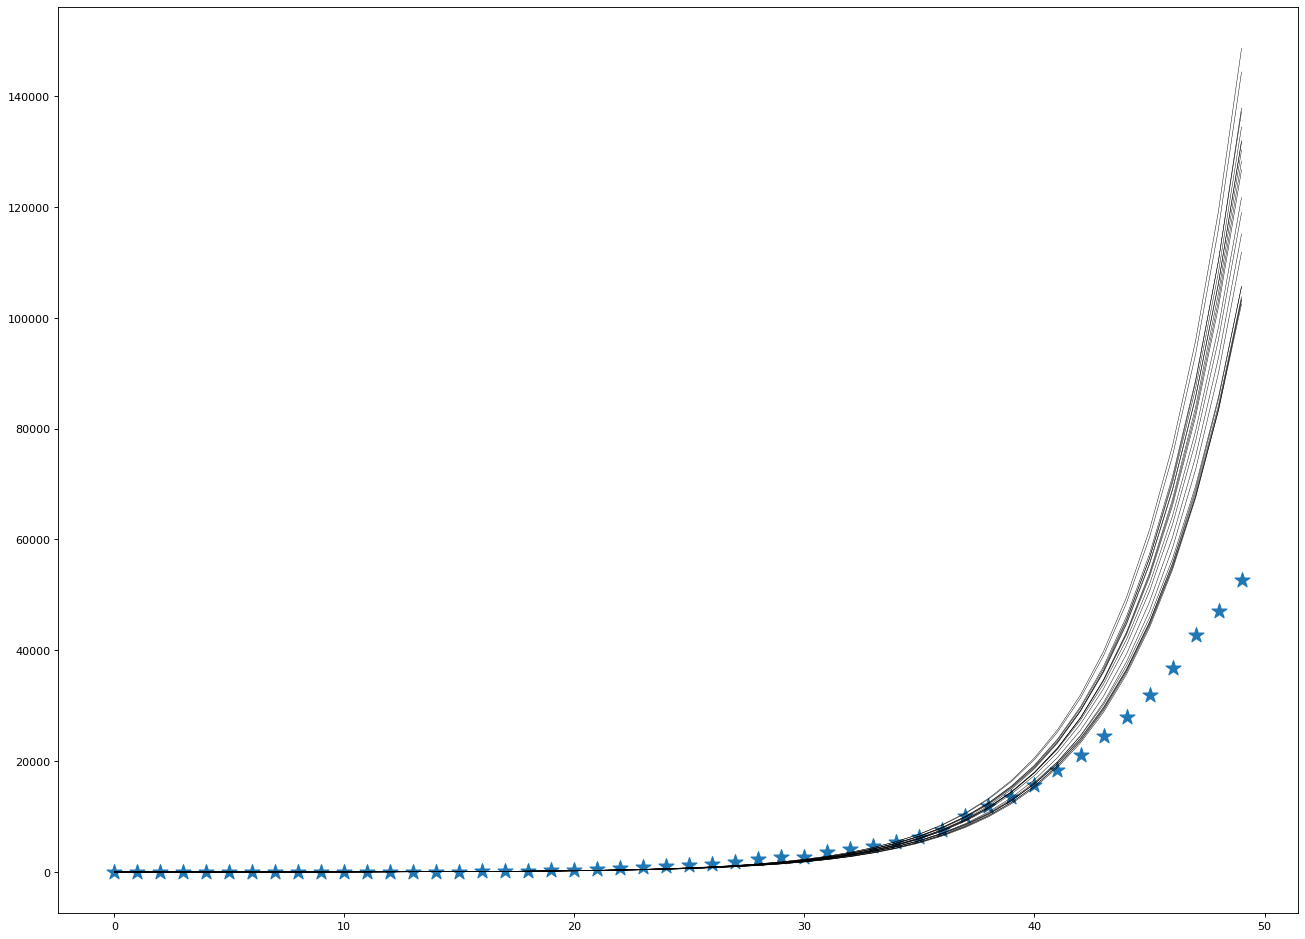

In [13]:
myplot_sample_exp(cur_mu, cur_sigma, points=[xd, data])

На обучении внешне выглядит не так уж и плохо, но так как мы строили экспоненты, на точках дальше ошибка будет гораздо больше. Дисперсия наших ошибок возрастает. 

Чтобы в этом убедится, сделаем прогнозы на несколько месяцев вперед. Для удобства будем пользоваться обученой на первом шаге линейной регрессией, так как апостериорная оценка параметров оказалась очень и очень близкой.

In [14]:
def predict_sample_exp(mu, sigma, x, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = []
    for i,w in enumerate(my_w):
        res.append(np.exp(w[0] + w[1]*x))
    return np.mean(res)

In [15]:
BASE_DATE = datetime(2020, 3, 3)

new_cases_at = lambda date: predict_sample_exp(cur_mu, cur_sigma, np.array([(date - BASE_DATE).days]))

for date in [datetime(2020, 5, 1), datetime(2020, 6, 1), datetime(2020, 9, 1)]:
    print(f"Число случаев {date.strftime('%b-%d')}: {new_cases_at(date)}")

Число случаев May-01: 1041844.8875599273
Число случаев Jun-01: 793848499.2683351
Число случаев Sep-01: 3.7441216980932576e+17


Легко видеть, что по нашим предсказаниям только за первого июня число заболевших больше населения России в 6 раз, а первого сентября уже на порядки больше населения земного шара.

# 3. Гауссиана вместо экспоненты


$$\Phi(x) = \frac{1}{\sqrt2\pi}\int_{-\infty}^{x}\exp(-t^2/2)dt$$

# 3.1. Сведение к задаче линейной регрессии

Для того, чтобы свести эту задачу к обучению линейной регрессии рассмотрим производную этой функции:

$$
\frac{\partial\Phi(x)}{\partial x} = \frac{1}{ \sqrt2\pi} e^{at^2 + bt + c}
$$
И теперь аналогичный второму пункту трюк с логарифмом
$$
\ln \frac{\partial\Phi(x)}{\partial x} = at^2 + bt + c
$$

Нам повездо и производная для `total_cases` это и есть `new_cases`, достаточно взять от нее логарифм и повторить все действия из второго пункта.

## 3.2. Линейная регрессия

In [16]:
y_train = np.log(train['new_cases'])
y_test = np.log(test['new_cases'])

X_train = np.vstack(
    (
        np.array(train.index),
        np.array(train.index) * np.array(train.index),
    )
).T

X_test = np.vstack(
    (
        np.array(test.index),
        np.array(test.index) * np.array(test.index)
    )
).T

lin_reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)

y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

In [17]:
total_cases_pred_train = np.cumsum(np.exp(y_pred_train))
total_cases_pred_test = np.cumsum(np.exp(y_pred_test))

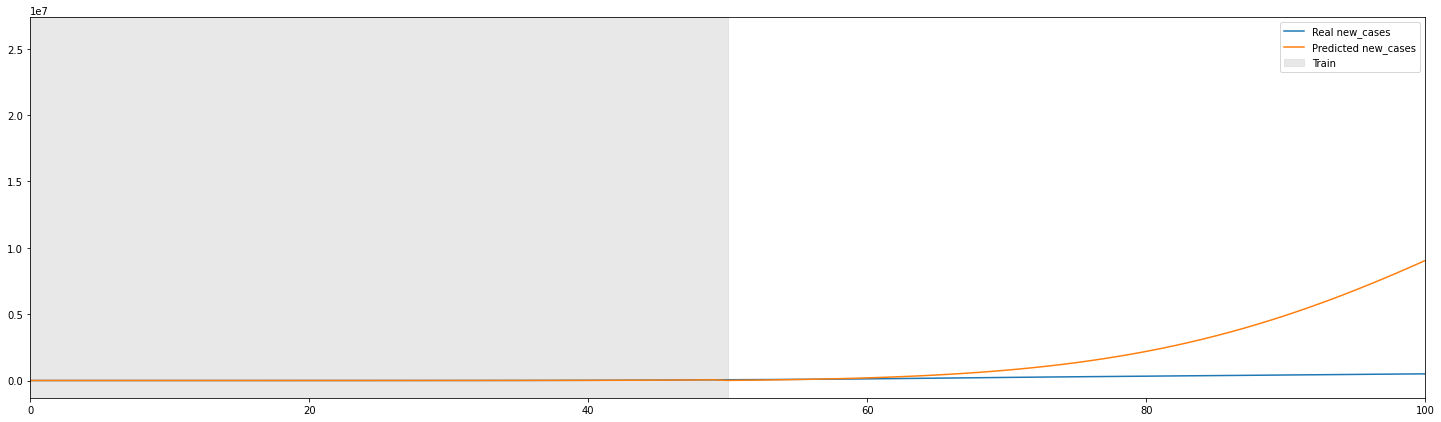

In [18]:
fig, ax = plt.subplots(figsize=(25, 7))

ax.plot(
    np.hstack((np.array(train.index), np.array(test.index))),
    np.hstack((train['total_cases'], test['total_cases'])), 
    label='Real new_cases'
)

ax.plot(
    np.hstack((np.array(train.index), np.array(test.index))),
    np.hstack((total_cases_pred_train, total_cases_pred_test)),
    label='Predicted new_cases'
)

ax.axvspan(0, 50, alpha=0.5, label = 'Train', color='lightgrey')
ax.set_xlim((0, 100))

plt.legend()
plt.show()

Получается тоже не очень хорошо, видимо для обучения нужно брать больше точек, чем первые 50 наблюдений. Перестроим для 100 точек.

In [19]:
cases_rus = (
    cases[(cases['location'] == 'Russia') & (cases['date'] >= '2020-03-03')]
    .sort_values('date')
    .reset_index(drop=True)
)

cases_rus['new_cases'] = np.where(cases_rus['new_cases'] == 0.0, 1.0, cases_rus['new_cases'])

train = cases_rus.iloc[:100]#.reset_index(drop=True)
test = cases_rus.iloc[100:]#.reset_index(drop=True)

print(f"Train shape : {train.shape}")
print(f"Train shape : {test.shape}")

Train shape : (100, 67)
Train shape : (1013, 67)


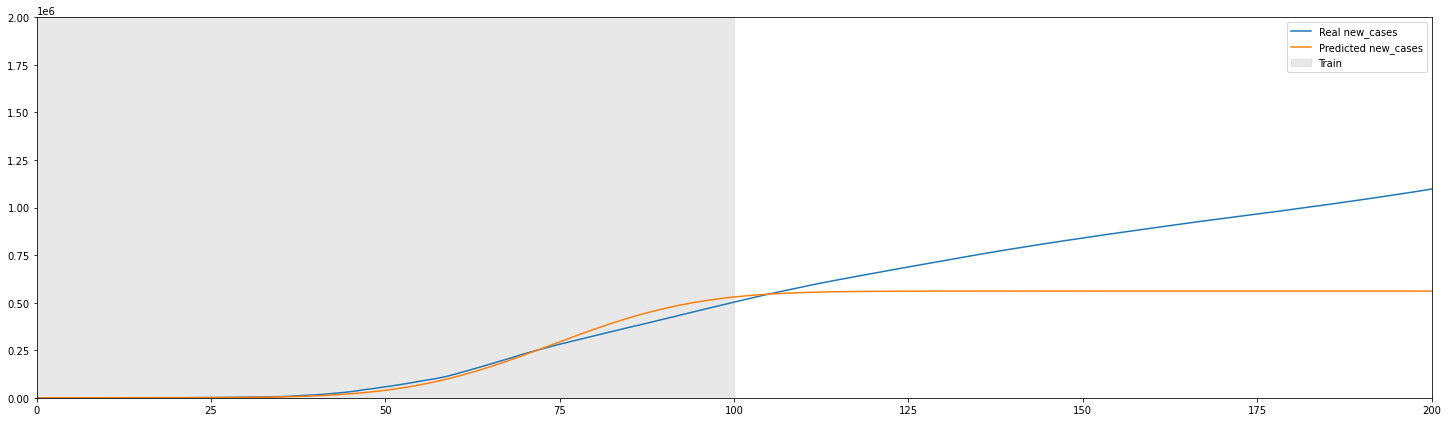

In [20]:
y_train = np.log(train['new_cases'])
y_test = np.log(test['new_cases'])

X_train = np.vstack(
    (
        np.array(train.index),
        np.array(train.index) * np.array(train.index),
    )
).T

X_test = np.vstack(
    (
        np.array(test.index),
        np.array(test.index) * np.array(test.index)
    )
).T

lin_reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)

y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

total_cases_pred_train = np.cumsum(np.exp(y_pred_train))
total_cases_pred_test = total_cases_pred_train[-1] + np.cumsum(np.exp(y_pred_test))

fig, ax = plt.subplots(figsize=(25, 7))

ax.plot(
    np.hstack((np.array(train.index), np.array(test.index))),
    np.hstack((train['total_cases'], test['total_cases'])), 
    label='Real new_cases'
)

ax.plot(
    np.hstack((np.array(train.index), np.array(test.index))),
    np.hstack((total_cases_pred_train, total_cases_pred_test)),
    label='Predicted new_cases'
)

ax.axvspan(0, 100, alpha=0.5, label = 'Train', color='lightgrey')
ax.set_xlim((0, 200))
ax.set_ylim(0, 2e6)

plt.legend()
plt.show()

Сколько точек не бери, а истинное распределение так и так расходится с предсказанным. Видимо априорное распределение выбрано не так уж удачно. Посмотрим, какие получились веса у этой модели

In [21]:
print("bias=", lin_reg.intercept_)
print("coef=", lin_reg.coef_)

bias= -0.933714207969647
coef= [ 0.28083768 -0.00188472]


## 3.3 Байесовский вывод

In [22]:
def bayesian_update_vanilla(mu, sigma, x, y, sigma_noise=.25):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), x) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), y) ) 
    return mu_n, sigma_n

In [23]:
num_steps = X_train.shape[0]
cur_mu = np.zeros(3)
cur_sigma = 5 * np.eye(3)
sigma_noise = np.std(y_train - y_pred_train)

X_train = np.hstack(
    (
        np.ones((X_train.shape[0], 1)),
        X_train
    )
)

print(f"Mu shape: {cur_mu.shape}")
print(f"Sigma shape: {cur_sigma.shape}")

cur_mu, cur_sigma = bayesian_update_vanilla(cur_mu, cur_sigma, X_train, y_train, sigma_noise)

print(f"Апостериорное распределение параметров: {cur_mu}")

Mu shape: (3,)
Sigma shape: (3, 3)
Апостериорное распределение параметров: [-0.92118907  0.28033206 -0.00188047]


## 3.4 Сэмплируем и строим гауссианы

In [24]:
def myplot_sample_sigmoid(mu, sigma, X, n=20, points=None):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    plt.figure(figsize=(20, 15), dpi=80)
    for w in my_w:
        plt.plot(X[:,1], np.cumsum(np.exp(np.matmul(X, w.T))), 'k-', lw=.4)
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
    plt.show()

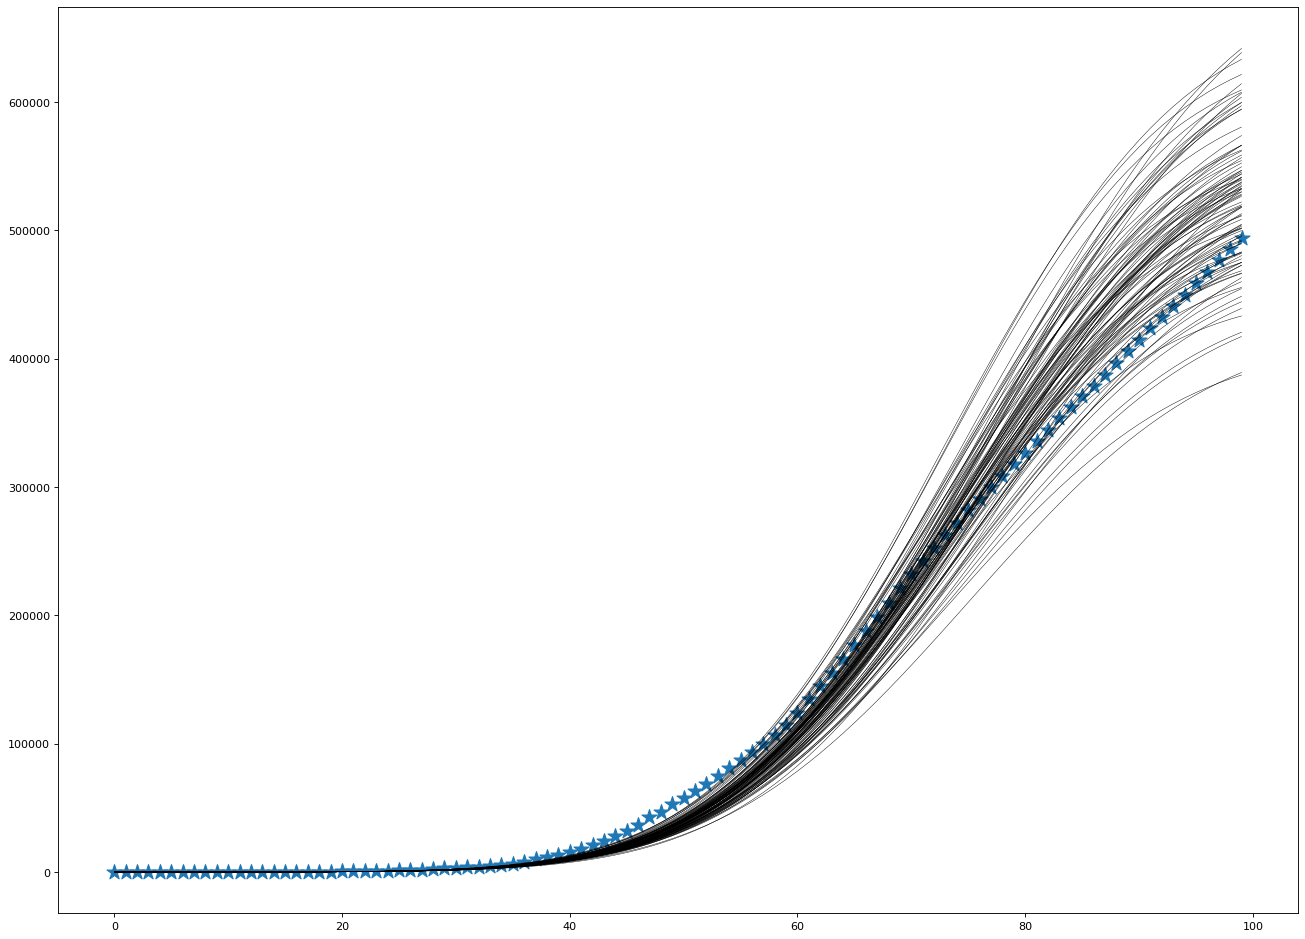

In [25]:
myplot_sample_sigmoid(cur_mu, cur_sigma, X_train, n=100, points=[X_train[:,1], train.total_cases])

Сделаем пессиместичный и оптимистичный прогнозы на каждый из дней предыдущего пункта

In [26]:
def predict_sample_sigmoid(mu, sigma, day, n=20):
    x = np.vstack(
        (
            np.ones(day),
            np.arange(1, day + 1),
            np.arange(1, day + 1) * np.arange(1, day + 1),
        )
    ).T
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = []
    for i,w in enumerate(my_w):
        res.append(np.cumsum(np.exp(np.matmul(x, w.T)))[-1])
    return np.quantile(res, 0.9), np.quantile(res, 0.1)

In [27]:
BASE_DATE = datetime(2020, 3, 3)

new_cases_at = lambda date: predict_sample_sigmoid(cur_mu, cur_sigma, (date - BASE_DATE).days)

for date in [datetime(2020, 5, 1), datetime(2020, 6, 1), datetime(2020, 9, 1)]:
    worst_case, best_case = map(int, new_cases_at(date))
    print(f"Число случаев {date.strftime('%b-%d')}: в худшем случае {worst_case} и в лучшем случае {best_case}")

Число случаев May-01: в худшем случае 108613 и в лучшем случае 88446
Число случаев Jun-01: в худшем случае 541975 и в лучшем случае 414880
Число случаев Sep-01: в худшем случае 633135 и в лучшем случае 505133


Теперь полученный прогноз гораздо лучше и правдоподобнее!